In [3]:
import pandas as pd
import os

# Folder containing CSVs with sequences of loss values
folder_path = r'C:\Users\daV\Documents\ZHAW\HS 2024\dPoDL\dPoDL\experiments\filtered-search\cnns\mnist\sparse-categorical'

# List to hold sequences
sequences = []

# Load all CSVs and extract sequences of loss values
for filename in [i for i in os.listdir(folder_path) if i.endswith(".csv")]:
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            data = pd.read_csv(file_path)
            if len(data) >= 5:
                sequences.append(data['Loss'].values)  # assuming the column is named 'loss'
        except:
            print(filename)


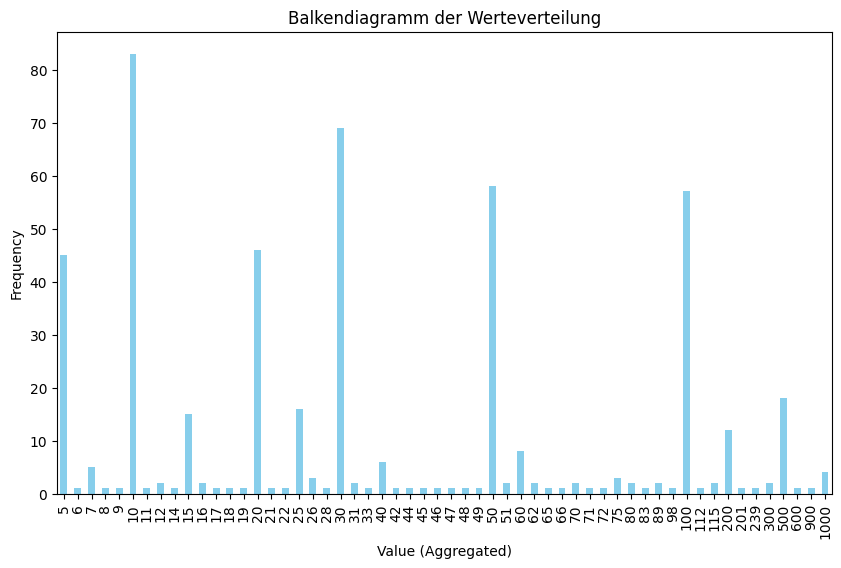

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Generate or load a large dataset
data = [len(df) for df in sequences]  # List of counts per DataFrame in sequences

# Convert data to a DataFrame for easy manipulation
df = pd.DataFrame(data, columns=['count'])

# Optional: Aggregate data to reduce the number of bars (e.g., by frequency counts)
df['count'].value_counts().sort_index().plot(kind='bar', color='skyblue', figsize=(10, 6))

plt.xlabel('Value (Aggregated)')
plt.ylabel('Frequency')
plt.title('Balkendiagramm der Werteverteilung')
plt.show()

In [11]:
import numpy as np

# Define window sizes
input_window = 5  # Input sequence length (n)
output_window = 3  # Output sequence length (m)

# Prepare input-output pairs from sequences
X = []
y = []

for sequence in sequences:
    # Create input-output pairs for each sequence
    for i in range(len(sequence) - input_window - output_window):
        X.append(sequence[i:i+input_window])
        y.append(sequence[i+input_window:i+input_window+output_window])

# Convert to numpy arrays for easier manipulation
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((30572, 5), (30572, 3))

# Visualize Data

outliers: 18


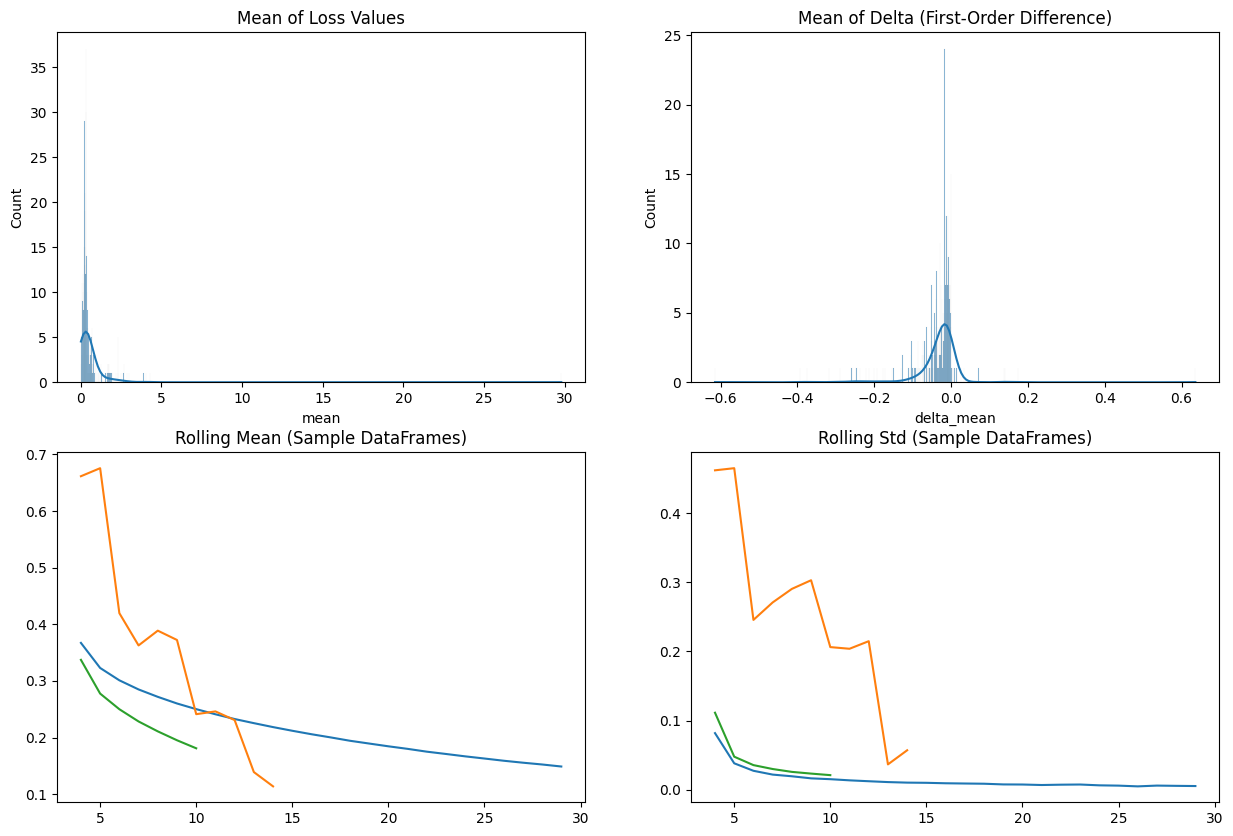

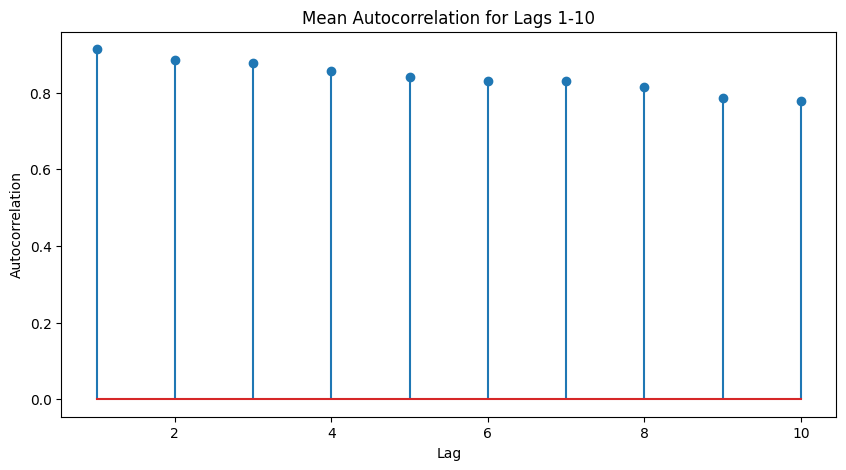

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

def analyze_loss_timeseries(dataframes):
    summary_stats = []
    outliers = 0
    
    for df in dataframes:
        # Convert the loss data to a Pandas Series if it's an ndarray
        loss = pd.Series(df) if isinstance(df, np.ndarray) else df['loss']
        
        # Remove NaN values from the series
        loss = loss.dropna()
        
        # Only proceed if there is enough data in the series
        if len(loss) < 2:
            continue
        
        # First-order difference (delta)
        delta = loss.diff().dropna()
        if any([True for i in list(delta) if abs(i)>10]):
            outliers += 1
            continue
        
        # Rolling statistics
        rolling_mean = loss.rolling(window=5).mean()
        rolling_std = loss.rolling(window=5).std()
        
        # Autocorrelation for lags up to 10
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            autocorr = [loss.autocorr(lag=i) if len(loss) > i else np.nan for i in range(1, 11)]
        
        # Store in a summary dictionary
        stats = {
            'mean': loss.mean(),
            'median': loss.median(),
            'std': loss.std(),
            'delta_mean': delta.mean(),
            'delta_std': delta.std(),
            'autocorr': autocorr
        }
        summary_stats.append(stats)
    print("outliers:", outliers)
    summary_df = pd.DataFrame(summary_stats)
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histogram of mean and delta mean
    sns.histplot(summary_df['mean'], bins=2000, ax=axes[0, 0], kde=True).set(title='Mean of Loss Values')
    sns.histplot(summary_df['delta_mean'], bins=2000, ax=axes[0, 1], kde=True).set(title='Mean of Delta (First-Order Difference)')
    
    # Manually sample dataframes for rolling mean and std plots
    sample_dataframes = random.sample(dataframes, min(3, len(dataframes)))
    for df in sample_dataframes:
        loss = pd.Series(df) if isinstance(df, np.ndarray) else df['loss']
        rolling_mean = loss.rolling(window=5).mean()
        rolling_std = loss.rolling(window=5).std()
        
        axes[1, 0].plot(rolling_mean, label='Rolling Mean')
        axes[1, 1].plot(rolling_std, label='Rolling Std')
    
    axes[1, 0].set_title('Rolling Mean (Sample DataFrames)')
    axes[1, 1].set_title('Rolling Std (Sample DataFrames)')
    plt.show()
    
    # Autocorrelation plot for lags 1-10
    plt.figure(figsize=(10, 5))
    autocorr_means = np.nanmean([stats['autocorr'] for stats in summary_stats if 'autocorr' in stats], axis=0)
    plt.stem(range(1, 11), autocorr_means)
    plt.title('Mean Autocorrelation for Lags 1-10')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    return summary_df

# Usage
summary_df = analyze_loss_timeseries(sequences)


In [6]:
sequences[0]

array([4.087 , 0.717 , 0.6068, 0.5337, 0.5029, 0.4939, 0.4827, 0.4735,
       0.4681, 0.4684, 0.4619, 0.4618, 0.4547, 0.4581, 0.4561, 0.4497,
       0.4515, 0.448 , 0.4441, 0.4404])

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class LossPredictionTransformer(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3):
        super(LossPredictionTransformer, self).__init__()
        
        # Input and output embeddings for the transformer (linear layers for simplicity)
        self.input_embedding = nn.Linear(input_size, d_model)
        self.output_embedding = nn.Linear(input_size, d_model)
        
        # Transformer model
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers
        )
        
        # Final output layer to map to single loss value predictions
        self.fc_out = nn.Linear(d_model, input_size)

    def forward(self, src, tgt):
        # Embed the input and output sequences
        src_emb = self.input_embedding(src)
        tgt_emb = self.output_embedding(tgt)
        
        # Pass through the transformer
        transformer_output = self.transformer(src_emb, tgt_emb)
        
        # Map to final predictions
        output = self.fc_out(transformer_output)
        return output

# Initialize model
model = LossPredictionTransformer()


In [9]:
import sys
len(X_tensor.view(-1).tolist())  # 10M entries!

NameError: name 'X_tensor' is not defined

In [13]:
import torch.optim as optim
import time
from torch.utils.data import DataLoader, TensorDataset
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Add an extra dimension for input size
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Create a dataset and a data loader with batching
dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 128     #   128 BS  0.15s/batch  ->  1585 batches = 237s   32 BS  0.07s/batch  -> 6338 Batches = 443s
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with batches
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (X_batch, y_batch) in enumerate(data_loader):
        # Zero gradients
        optimizer.zero_grad()
        
        # Transformer expects (sequence_length, batch_size, d_model) shaped tensors
        X_train = X_batch.permute(1, 0, 2)  # (sequence_length, batch_size, input_size)
        y_train = y_batch.permute(1, 0, 2)
        
        # Predict next loss values
        output = model(X_train, y_train[:-1])  # Use teacher forcing for now
        
        # Compute the loss
        loss = criterion(output, y_train[1:])  # Compare against the actual future loss values
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate the batch loss
        epoch_loss += loss.item()

        # Print batch progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{len(data_loader)}, Batch Loss: {loss.item()}")


Epoch 1/10, Batch 1/239, Batch Loss: 34219.359375
Epoch 1/10, Batch 2/239, Batch Loss: 24782.69921875
Epoch 1/10, Batch 3/239, Batch Loss: 17487.755859375
Epoch 1/10, Batch 4/239, Batch Loss: 12842.0595703125
Epoch 1/10, Batch 5/239, Batch Loss: 19157.328125
Epoch 1/10, Batch 6/239, Batch Loss: 14511.259765625
Epoch 1/10, Batch 7/239, Batch Loss: 17544.86328125
Epoch 1/10, Batch 8/239, Batch Loss: 36230.0546875
Epoch 1/10, Batch 9/239, Batch Loss: 14272.541015625
Epoch 1/10, Batch 10/239, Batch Loss: 430793.4375
Epoch 1/10, Batch 11/239, Batch Loss: 21324.607421875
Epoch 1/10, Batch 12/239, Batch Loss: 161803760.0
Epoch 1/10, Batch 13/239, Batch Loss: 15476.029296875
Epoch 1/10, Batch 14/239, Batch Loss: 4011122.0
Epoch 1/10, Batch 15/239, Batch Loss: 8059.841796875
Epoch 1/10, Batch 16/239, Batch Loss: 40196.25
Epoch 1/10, Batch 17/239, Batch Loss: 8078.0732421875
Epoch 1/10, Batch 18/239, Batch Loss: 10120.0634765625
Epoch 1/10, Batch 19/239, Batch Loss: 10616.9013671875
Epoch 1/10, 

In [15]:
def predict_next_losses(model, input_sequence, output_length=5):
    model.eval()
    
    # Convert input to tensor and reshape
    input_tensor = torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # (1, seq_len, 1)
    input_tensor = input_tensor.permute(1, 0, 2)  # (sequence_length, batch_size, input_size)
    
    # Prepare initial target tensor with zeros
    target_tensor = torch.zeros(output_length, 1, 1)  # (output_length, batch_size, input_size)
    
    # Predict next loss values
    with torch.no_grad():
        predicted_loss = model(input_tensor, target_tensor)
    
    return predicted_loss.squeeze(-1).numpy()

# Example prediction
input_sequence = X[0]  # Use one of the training sequences
predicted_losses = predict_next_losses(model, input_sequence)
print("Predicted next losses:", predicted_losses)
y[0]


Predicted next losses: [[-0.10709388]
 [-0.10709388]
 [-0.10709388]
 [-0.10709388]
 [-0.10709388]]


array([0.4939, 0.4827, 0.4735])